# Part 3: State of the Art Comparison (2 points)

- **Objective:** Benchmark your model against the SOA with the full dataset now available.

- **Tasks:**
  - **a. Full Dataset Training (0.25 points):** Incrementally train your model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%). Record the results.
  - **b. Learning Curve (0.25 points):** Plot a learning curve based on the training data percentages.
  - **c. Technique Comparison (0.5 points):** Incorporate the techniques tested in Part 2 into your training schema for comparison.
  - **d. Methodology Analysis (1 point):** Analyze and compare all methods employed. Discuss the effectiveness and limitations observed.

## Libraries

In [26]:
import numpy as np
import polars as pl
from library.utilities import set_seed, sample_balanced_dataset
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)
from library.incremental_train.doc import run_incremental_training, train_with_percentage
from library.fine_tuning import evaluate_best_finetuned_model
from library.metrics import evaluate_classification

In [2]:
# # specific for mac users with M1 chip (That do not have CUDA)
# # !pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu
# import torch
# print(torch.backends.mps.is_available())      # Is Metal available?
# print(torch.backends.mps.is_built()) 

In [3]:
# # detect if MPS (GPU in Mac) is available
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# x = torch.ones(3, 3).to(device)
# print(x)

In [4]:
# Set random seed for reproducibility
seed = 42
set_seed(42)

Seed set to 42. This ensures reproducibility of results across runs.


# 3.a) Full dataset training with increments

In [5]:
# Load the cleaned Parquet file
df = pl.read_parquet('data/FRENCH_swiss_judgment_prediction_combined.parquet')

# Display the loaded DataFrame
print("\nLoaded DataFrame shape:", df.shape)
print("\nLoaded DataFrame schema:")
print(df.schema)
print("\nFirst few rows of the loaded DataFrame:")
df.head()


Loaded DataFrame shape: (31094, 9)

Loaded DataFrame schema:
Schema({'id': Int32, 'year': Int32, 'text': String, 'labels': Int64, 'language': String, 'region': String, 'canton': String, 'legal area': String, 'split': String})

First few rows of the loaded DataFrame:


id,year,text,labels,language,region,canton,legal area,split
i32,i32,str,i64,str,str,str,str,str
0,2000,"""A.- Par contrat d'entreprise s…",0,"""fr""",null,null,"""civil law""","""train"""
1,2000,"""A.- Le 12 avril 1995, A._ a su…",0,"""fr""",null,null,"""insurance law""","""train"""
2,2000,"""A.- En février 1994, M._ a été…",0,"""fr""","""Région lémanique""","""ge""","""insurance law""","""train"""
3,2000,"""A.- M._ a travaillé en qualité…",0,"""fr""",null,null,"""insurance law""","""train"""
6,2000,"""A.- Le 29 septembre 1997, X._ …",0,"""fr""","""Espace Mittelland""","""ne""","""penal law""","""train"""


In [6]:
# Split the DataFrame into training, validation and test sets
train_df = df.filter(pl.col('split') == 'train')
val_df = df.filter(pl.col('split') == 'validation')
test_df = df.filter(pl.col('split') == 'test')

# Delete the original data to free up memory
del df

In [5]:
# # Load the train, validation and test Parquet files
# train_df = pl.read_parquet('data/FRENCH_swiss_judgment_prediction_train.parquet')
# valid_df = pl.read_parquet('data/FRENCH_swiss_judgment_prediction_valid.parquet')
# test_df = pl.read_parquet('data/FRENCH_swiss_judgment_prediction_test.parquet')

# # Display the loaded DataFrames
# print("\nTrain DataFrame shape:", train_df.shape)
# print("\nValidation DataFrame shape:", valid_df.shape)
# print("\nTest DataFrame shape:", test_df.shape)

# print("\nTrain DataFrame schema:")
# print(train_df.schema)
# print("\nFirst few rows of the train DataFrame:")
# train_df.head()

In [5]:
model_name = "almanach/camembert-base"  # Path to the pre-trained model
num_labels = 2  # Number of labels for the classification task (in this case, binary classification)
max_length = min(int(AutoModel.from_pretrained(model_name).config.max_position_embeddings), 512)  # Maximum length of the input sequences (truncation if larger than this). Set dynamically based on the chosen model.

print(f"Model: {model_name}, Max Length: {max_length}")

Model: almanach/camembert-base, Max Length: 512


In [ ]:
result1 = train_with_percentage(train_df, val_df, 1, model_name, max_length, num_labels, seed)

In [ ]:
result10 = train_with_percentage(train_df, val_df, 10, model_name, max_length, num_labels, seed)

In [ ]:
result25 = train_with_percentage(train_df, val_df, 25, model_name, max_length, num_labels, seed)

In [6]:
# Note that, due to the class imbalance, we will have to do sampling with replacement
# to get enough samples for the minority class
result50 = train_with_percentage(train_df, val_df, 50, model_name, max_length, num_labels, seed)

Using sampling with replacement for positive class (need 5294, have 5197)


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/10588 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.658000,0.794177,0.485945,0.385477,0.257216,0.768875
2,0.586400,0.646257,0.623263,0.383721,0.292035,0.559322
3,0.480600,0.760664,0.614540,0.398992,0.296407,0.610169
4,0.375800,0.846607,0.649111,0.410423,0.316848,0.582435
5,0.290200,0.849848,0.672375,0.401417,0.325359,0.523883
6,0.239100,1.258928,0.581583,0.396833,0.284379,0.656394
7,0.191100,1.214160,0.623910,0.408537,0.304776,0.619414


In [7]:
# Note that, due to the class imbalance, we will have to do sampling with replacement
# to get enough samples for the minority class
result75 = train_with_percentage(train_df, val_df, 75, model_name, max_length, num_labels, seed)

Using sampling with replacement for positive class (need 7942, have 5197)


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/15884 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.623500,0.590011,0.679806,0.386378,0.322981,0.480740
2,0.524000,0.604952,0.708562,0.368347,0.337612,0.405239
3,0.430100,0.718164,0.663328,0.355995,0.297214,0.443760
4,0.321100,0.835823,0.652342,0.364817,0.295694,0.476117
5,0.266000,0.867743,0.705008,0.366412,0.333333,0.406780
6,0.215700,1.084933,0.651373,0.375940,0.300926,0.500770


In [8]:
# Note that, due to the class imbalance, we will have to do sampling with replacement
# to get enough samples for the minority class
result100 = train_with_percentage(train_df, val_df, 100, model_name, max_length, num_labels, seed)

Using sampling with replacement for positive class (need 10589, have 5197)


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/21178 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.630000,0.633844,0.656866,0.395216,0.313460,0.534669
2,0.481600,0.647722,0.693376,0.359217,0.319712,0.409861
3,0.381200,0.741087,0.682714,0.370513,0.317234,0.445300
4,0.260200,0.950179,0.666882,0.376286,0.309761,0.479199
5,0.222100,1.031830,0.677221,0.361661,0.308952,0.436055
6,0.165900,1.173391,0.663328,0.358374,0.298462,0.448382


# 3.b)  Learning Curve

## 2.1. Learning Curve for different percentages

In [16]:
# First, we load all of the results for each of the different percentages
results1 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_1pct.parquet'))
results10 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_10pct.parquet'))
results25 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_25pct.parquet'))
results50 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_50pct.parquet'))
results75 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_75pct.parquet'))
results100 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_100pct.parquet'))

# Create a list to store the summary data for each percentage
summary_data = []

# Define the percentage and corresponding result dataframes
percentage_results = [
    (1, results1),
    (10, results10),
    (25, results25),
    (50, results50),
    (75, results75),
    (100, results100)
]

# Extract metrics for each percentage
for percentage, result_df in percentage_results:
    # Find the best epoch (lowest eval_loss)
    best_epoch_idx = result_df['eval_loss'].arg_min()  # Get the index of the best epoch
    best_epoch = result_df[best_epoch_idx]
    
    # Add to summary data
    summary_data.append({
        'percentage': percentage,
        'eval_loss': best_epoch['eval_loss'][0],
        'eval_accuracy': best_epoch['eval_accuracy'][0],
        'eval_f1': best_epoch['eval_f1'][0],
        'eval_precision': best_epoch['eval_precision'][0],
        'eval_recall': best_epoch['eval_recall'][0]
    })

# Create the summary DataFrame
summary_df = pl.DataFrame(summary_data)
display(summary_df)

percentage,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
i64,f64,f64,f64,f64,f64
1,0.632334,0.670436,0.234234,0.228404,0.24037
10,0.57981,0.707593,0.386441,0.345036,0.439137
25,0.577443,0.685299,0.383544,0.325456,0.466872
50,0.646257,0.623263,0.383721,0.292035,0.559322
75,0.590011,0.679806,0.386378,0.322981,0.48074
100,0.633844,0.656866,0.395216,0.31346,0.534669


In [17]:
import matplotlib.pyplot as plt

def plot_learning_curve(summary_df, metric='eval_accuracy'):
    """
    Plots a learning curve for the given metric from the summary DataFrame.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(summary_df['percentage'], summary_df[metric], marker='o', label=metric)
    plt.xlabel('Percentage of Training Data Used')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Learning Curve: {metric.replace("_", " ").title()} vs. Training Set Size')
    plt.grid(True)
    plt.xticks(summary_df['percentage'])
    plt.legend()
    plt.show()

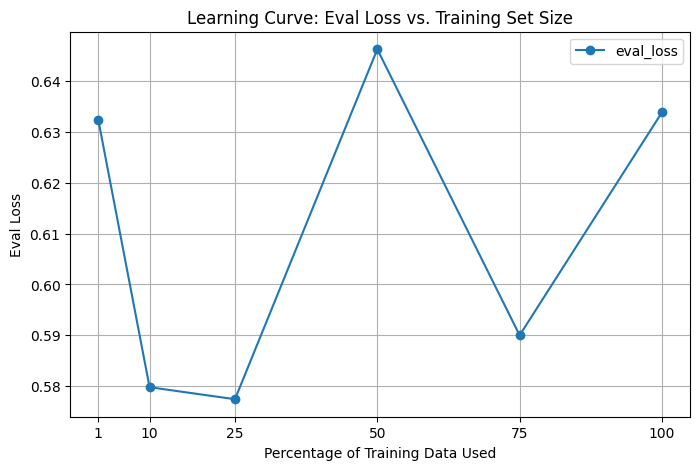

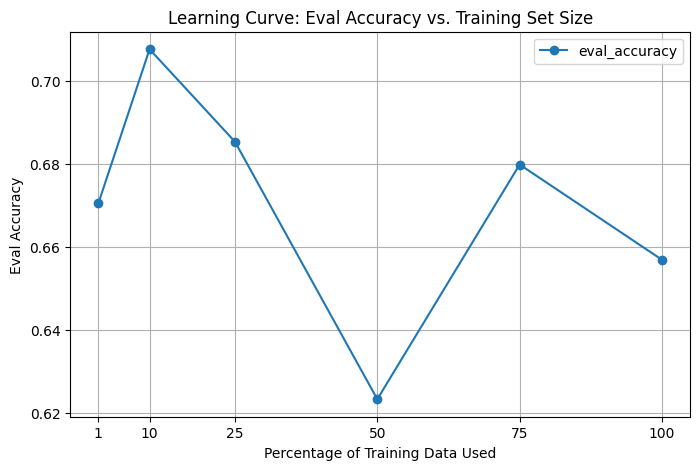

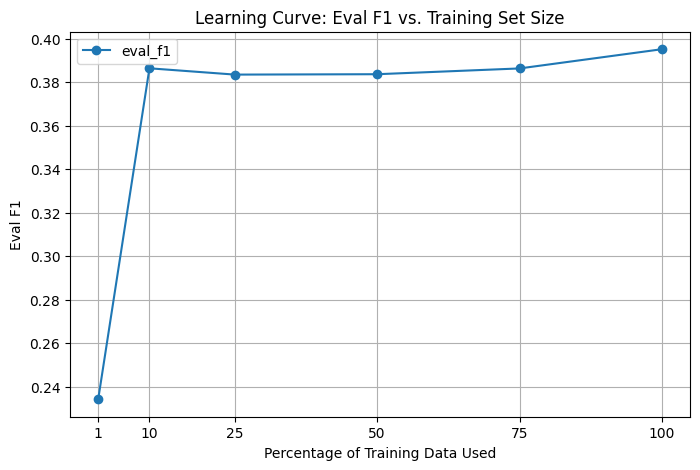

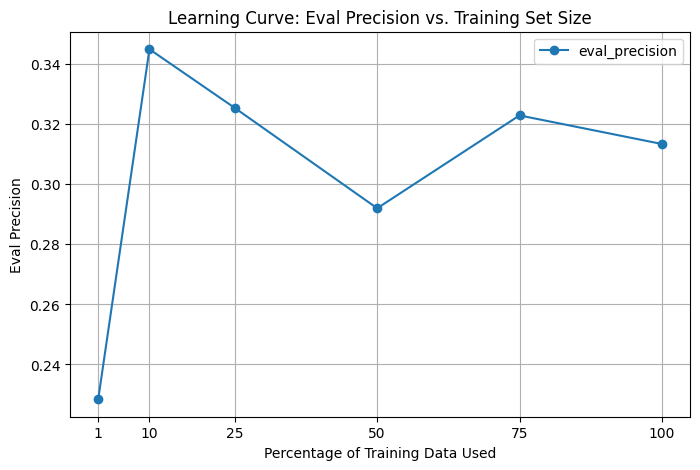

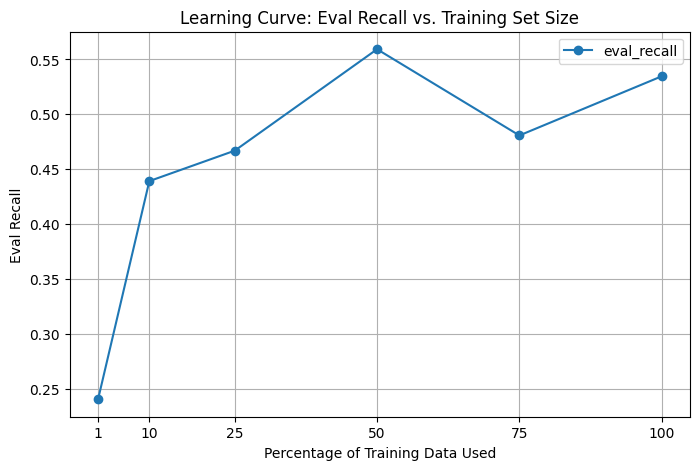

In [18]:
# Plot learning curve for different metrics
metrics = ['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']
for metric in metrics:
    plot_learning_curve(summary_df, metric)

## 2.2. Evaluation of full dataset model on the test set

In [25]:
# First, check the best checkpoint for the 100% training data (lowest validation loss)
display(results100)

loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.6845,0.496452,0.00002,0.075529,50,null,null,null,null,null,null,null,null,null,null,null,null,null
0.6727,0.90938,0.00002,0.151057,100,null,null,null,null,null,null,null,null,null,null,null,null,null
0.6758,0.673577,0.00002,0.226586,150,null,null,null,null,null,null,null,null,null,null,null,null,null
0.6674,0.780244,0.000019,0.302115,200,null,null,null,null,null,null,null,null,null,null,null,null,null
0.6591,1.161469,0.000019,0.377644,250,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.1782,16.246189,0.000008,5.81571,3850,null,null,null,null,null,null,null,null,null,null,null,null,null
0.1754,9.388947,0.000008,5.891239,3900,null,null,null,null,null,null,null,null,null,null,null,null,null
0.1659,5.173364,0.000008,5.966767,3950,null,null,null,null,null,null,null,null,null,null,null,null,null


The lowest validation loss was in the first epoch (after manually checking the data frame).

Loading model from: models/part_3/a/cls_fine_tuning_camembert-base_100pct/checkpoint-662
Loading tokenizer from: almanach/camembert-base
Sampling 500 rows from the test set...


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Making predictions on the test set...



Evaluating fine-tuned almanach/camembert-base on the test set:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       422
           1       0.22      0.50      0.30        78

    accuracy                           0.64       500
   macro avg       0.55      0.59      0.53       500
weighted avg       0.78      0.64      0.69       500



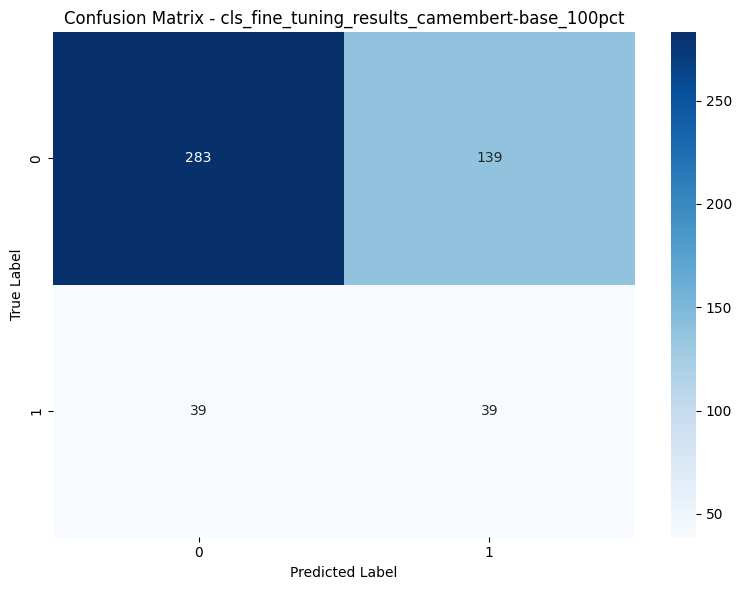

Unique labels found: [0, 1]
Label to index mapping: {0: 0, 1: 1}
First 5 TRUE sorbinary labels for ROC/PR curves: [0 0 0 1 0]
First 5 predicted probabilities for ROC/PR curves: [0.4400294  0.62301356 0.2286164  0.78867614 0.53836006]


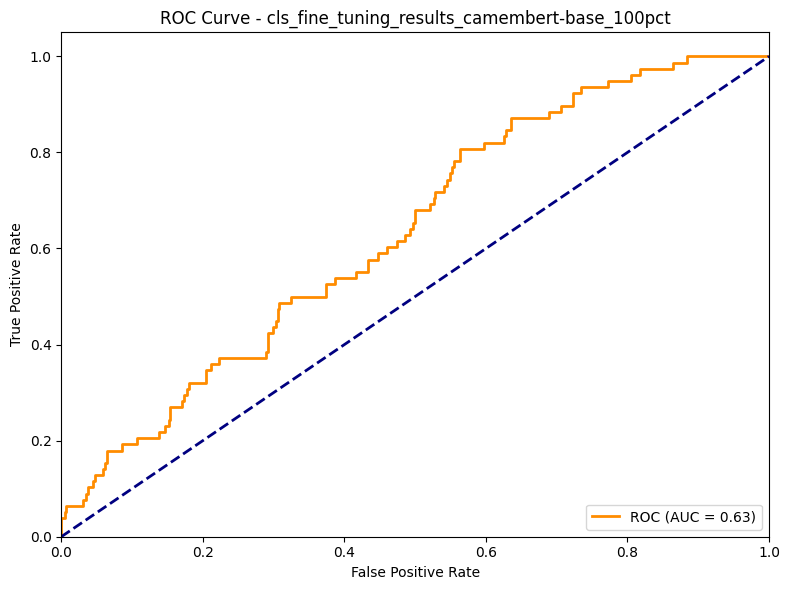

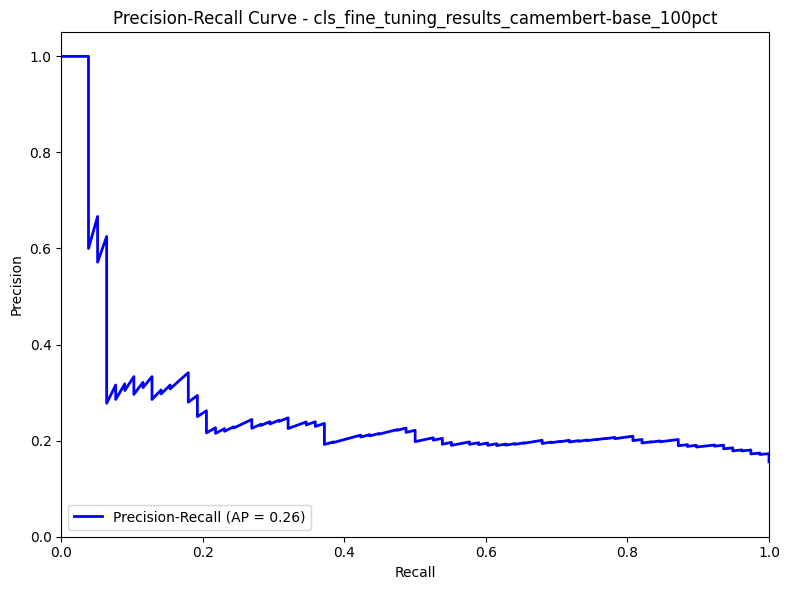

In [28]:
# Evaluate the best fine-tuned model with CamemBERT
max_length = 512  # Maximum length used in training (can be adjusted based on the model)
model_name = "almanach/camembert-base"  # Original model name for tokenizer
sample_size = 500  # Sample size for the test set (optional, can be adjusted)

# First, we determine the best checkpoint directory based on the training results
# (see above)
checkpoint = 662  # This is the index for the best checkpoint based on eval_loss (first available checkpoint)
best_checkpoint_directory = os.path.join('models', 'part_3', 'a', f'cls_fine_tuning_{model_name.split('/')[1]}_100pct', f'checkpoint-{checkpoint}')

# Ensure test_df has 'labels' column, not 'label'
if 'label' in test_df.columns and 'labels' not in test_df.columns:
    test_df = test_df.rename({'label': 'labels'})
    
y_true_test, y_pred_test, ft_probas = evaluate_best_finetuned_model(
    test_df=test_df, # Your Polars test DataFrame
    model_checkpoint_path=best_checkpoint_directory, # Path to the best checkpoint
    original_model_name=model_name, # Original model name for tokenizer
    max_length=max_length, # Max length used in training
    sample_size=sample_size, # Sample size for the test set (optional, can be adjusted)
    seed=seed  # Random seed for reproducibility
)

print(f"\nEvaluating fine-tuned {model_name} on the test set:")
finetuned_results = evaluate_classification(
    y_true=y_true_test,
    y_pred=y_pred_test,
    base_filename=f"cls_fine_tuning_results_{model_name.split('/')[1]}_100pct",
    labels=[0, 1],
    probas=ft_probas, # Probabilities for the positive class
    results_dir=os.path.join('results', 'part_3', 'a', 'test')
)

# 3.c) Technique Comparison

In [ ]:
import matplotlib.pyplot as plt
from library.incremental_train.doc import run_incremental_training

# Model names
model_names = [
    "almanach/camembert-base",
    "dascim/juribert-base",
    "google-bert/bert-base-multilingual-cased"
]

# Dictionary to store the results
results = {}

# Train each model 
for model_name in model_names:
    print(f"\nEntrenando modelo: {model_name}")
    summary_df = run_incremental_training(
        train_df=train_df,
        valid_df=val_df,
        model_name=model_name,
        max_length=max_length,
        num_labels=num_labels,
        seed=seed
    )
    results[model_name] = summary_df

# Graph the learning curves
def plot_comparison(results, metric='eval_accuracy'):
    plt.figure(figsize=(8, 5))
    for model_name, summary_df in results.items():
        plt.plot(summary_df['percentage'], summary_df[metric], marker='o', label=model_name.split('/')[-1])
    plt.xlabel('Percentage of Training Data Used')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Learning Curve Comparison: {metric.replace("_", " ").title()}')
    plt.grid(True)
    plt.xticks([1, 10, 25, 50, 75, 100])
    plt.legend()
    plt.show()

# Comparison of accuracy and F1 scores
plot_comparison(results, metric='eval_accuracy')
plot_comparison(results, metric='eval_f1')

# 3.d) Methodology Analysis

### Methodology Analysis

- **Domain-specific models** (`CamemBERT`, `JuriBERT`):  
  - Worked well for the **majority class** (``dismissal``), thanks to legal/French pre-training.
  - Struggled with the **minority class** (``approval``) due to **class imbalance** and few-shot data. For example, the model often predicted most ``dismissal`` cases correctly but missed many ``approval`` cases.

- **Zero-shot learning:**  
  - Used large language models without fine-tuning.
  - Predicted only the majority class (e.g., always ``dismissal``), failing to capture the complexity of ``approval`` cases.

- **Synthetic data augmentation:**  
  - Added new ``approval`` and ``dismissal`` samples using LLMs and retrained BERT.
  - **Effect:** Helped a bit with accuracy and class balance, but improvements were inconsistent and class imbalance remained a challenge.
 
Domain-specific fine-tuning (e.g., with `CamemBERT` or `JuriBERT`) outperformed zero-shot learning, but all methods were limited by data imbalance and scarce labels. **Zero-shot learning was ineffective, and synthetic data augmentation provided only partial improvement.** High-quality, diverse labeled data and better strategies for class imbalance are still needed for robust legal prediction.



#### Incrementally training `CamemBERT-base` 
With increasing percentages of the dataset, we observed that model performance (in terms of eval loss, accuracy, F1, precision, and recall) did not improve monotonically with more data. While there was a clear boost in all metrics when moving from very little data (1%) to a moderate amount (10–25%), further increases in training set size led to fluctuating results rather than steady improvement. 

Suggesting that, for this legal prediction task, simply adding more data is not always sufficient to guarantee better generalization—likely due to persistent class imbalance and the inherent complexity of the cases. These findings reinforce the need for not just more data, but also more balanced and diverse labeled examples.